# Creating a Rich GUI in the IPython Notebook

A modified version of [this original notebook](http://nbviewer.ipython.org/gist/bollwyvl/ddd4bf5d7c879012fa2c) by [Nicholas Bollweg](http://github.com/bollwyvl).

In [4]:
%matplotlib inline

from ipywidgets.widgets import (
    VBox, HBox, HTML, Box, RadioButtons,
    FloatText, Dropdown, Checkbox, Image, IntSlider, Button, FloatSlider,
)
from traitlets import (link, Unicode, Float, Int, Enum, Bool,)

CSS helps keep your code concise, as well as make it easier to extend/override.

In [5]:
%%html
<style>
/*
    This contents of this would go in a separate CSS file.

    Note the namespacing: this is important for two reasons.
    1) doesn't pollute the global namespace
    2) is _more specific_ than the base styles.
*/

.widget-area .spectroscopy .panel-body{
    padding: 0;
}
.widget-area .spectroscopy .widget-numeric-text{
    width: 5em;
}
.widget-area .spectroscopy .widget-box.start{
    margin-left: 0;
}
.widget-area .spectroscopy .widget-hslider{
    width: 12em;
}
    
</style>

These few classes wrap up some [Bootstrap components](http://getbootstrap.com/components/): these will be more consistent then coding up your own.

In [6]:
class PanelTitle(HTML):
    def __init__(self, *args, **kwargs):
        super(PanelTitle, self).__init__(*args, **kwargs)
        self.on_displayed(self.displayed)
    def displayed(self, _):
        self.add_class("panel-heading panel-title")

class PanelBody(Box):
    def __init__(self, *args, **kwargs):
        super(PanelBody, self).__init__(*args, **kwargs)
        self.on_displayed(self.displayed)
    def displayed(self, _):
        self.add_class("panel-body")

class ControlPanel(Box):
    # A set of related controls, with an optional title, in a box (provided by CSS)
    def __init__(self, title=None, *args, **kwargs):
        super(ControlPanel, self).__init__(*args, **kwargs)
        
        # add an option title widget
        if title is not None:
            
            self.children = [
                PanelTitle(value=title),
                PanelBody(children=self.children)
            ]

        self.on_displayed(self.displayed)
    
    def displayed(self, _):
        self.add_class("panel panel-info")

This notional `Spectrogram` shows how one might make a widget that redraws based on the state of its data. By defining its external API, including allowed and default values, in the form of [linked traitlets](http://ipython.org/ipython-doc/dev/api/generated/IPython.utils.traitlets.html#IPython.utils.traitlets.link), it can be reused without replumbing any events, while a few simple methods like `draw` make sure it is still easy to use in a programmatic way.

In [9]:
def html_figure(fig, title="Figure"):
    
    from IPython.core.pylabtools import print_figure
    import base64

    fdata64 = base64.b64encode(print_figure(fig))
    html_tpl = '<img alt="{title}" src="data:image/png;base64,{fdata64}">'
    return html_tpl.format(**locals())

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: metadata {'sync': True} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  import sys
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead


A Jupyter Widget

audio: 10959


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

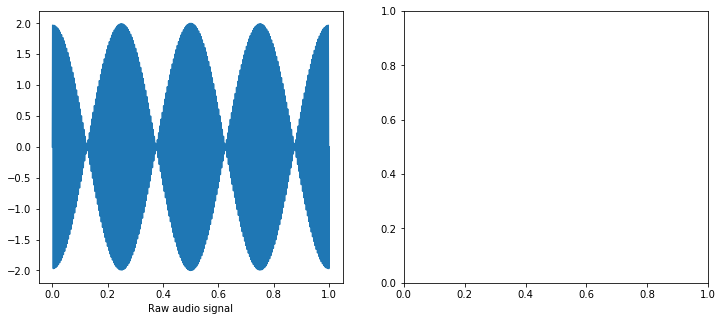

In [10]:
class AudioBeats(HTML):
    """
    A notional "complex widget" that knows how to redraw itself when key properties change.
    """

    # Signal parameters
    L = Float(1, sync=True)
    f1 = Float(220, sync=True)
    f2 = Float(224, sync=True)
    rate = 4000.0
    
    def __init__(self, *args, **kwargs):
        """
        Creates a spectrogram
        """
        super(AudioBeats, self).__init__(*args, **kwargs)
        self.on_trait_change(lambda name, old, new: self.draw(name, old, new))
        self.on_displayed(self.displayed)

    def displayed(self, _):
        self.add_class("col-xs-9")
        self.draw()
    
    def draw(self, name=None, old=None, new=None):        
        # Make figure with random data. Replace with real application here
        import matplotlib.pyplot as plt
        import numpy as np
        plt.rcParams['figure.figsize'] = (6,4)
        
        # Audio
        from IPython.display import Audio
        
        times = np.linspace(0, self.L, self.rate*self.L)
        signal = np.sin(2*np.pi*self.f1*times) + np.sin(2*np.pi*self.f2*times)

        html_audio = Audio(data=signal, rate=self.rate)._repr_html_()
        print('audio:', len(html_audio))
        
        # figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(times, signal); ax1.set_xlabel('Raw audio signal')
        ax2.specgram(signal); ax2.set_xlabel('Spectrogram');
        fig.suptitle(r'$s(t) = \sin(2\pi f_1 t) + \sin(2 \pi f_2 t)$', fontsize=20)
        plt.close(fig)
        html_fig = html_figure(fig)
        
        # WATCH THIS! setting value to an html string with the figure data
        # is what will show the plot in the final render:
        value = r"""
        {html_fig}
        <p>
        {html_audio}
        """.format(**locals())
                
        self.value = value
        
AudioBeats()

The actual GUI. Note that the individual components of the view are responsible for:
- creating widgets
- linking to the graph widget

In [13]:
class BeatsExplorer(Box):
    """
    An example GUI for a spectroscopy application.
    
    Note that `self.graph` is the owner of all of the "real" data, while this
    class handles creating all of the GUI controls and links. This ensures
    that the Graph itself remains embeddable and rem
    """
    def __init__(self, graph=None, graph_config=None, *args, **kwargs):
        self.graph = graph or AudioBeats(**(graph_config or {}))
        # Create a GUI
        kwargs["children"] = [VBox(children = 
                                  [self._controls(), self.graph])]
        super(BeatsExplorer, self).__init__(*args, **kwargs)
        
        self.on_displayed(self.displayed)

    def displayed(self, _):
        # namespace and top-level bootstrap
        self.add_class("spectroscopy row")
        
    def _controls(self):
        panels = VBox(children=[
            self._spectrum(),
        ])
        panels.on_displayed(lambda x: panels.add_class("col-xs-3"))
        return panels
    
    def _spectrum(self):
        # create spectrum controls.  NOTE: should only be called once.
        f1 = FloatSlider( description="f1", min=220, max=230, value=225)
        link( (f1, "value"), (self.graph, "f1"))

        f2 = FloatSlider(description="f2", min=225, max=235, value=228)
        link((f2, "value"), (self.graph, "f2"))
        
        freqs = VBox(children=[f1, f2])

        L = FloatSlider(description="L", min=0.5, max=3, value=1)
        link((L, "value"), (self.graph, "L"))

        rate = FloatSlider(description="rate", min=10, max=2000, value=1000)
        link((rate, "value"), (self.graph, "rate"))        
        
        time_ctrls = VBox(children=[L, rate])
        
        return ControlPanel(title="Audio Beats",
            children=[HBox(children=[freqs, time_ctrls])] )

Hooray, everything is defined, now we can try this out!

In [14]:
BeatsExplorer()

audio: 10959
audio: 10959
audio: 10959
audio: 10959
audio: 2959
audio: 2959
audio: 3223
audio: 3223
audio: 3491
audio: 3491
audio: 4367
audio: 4367
audio: 4367
audio: 4367
audio: 4367
audio: 4367
audio: 4367
audio: 4367
audio: 4367
audio: 4367
